# LDA
Use covariance shrinkage for better LDA (Linear Discriminant Analysis)

It seems that the choice of epsilon is crucial and leave 1 out CV is not always ideal. Can we devise another method/theoretical approach?

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import covariance_DRO
from sklearn.covariance import LedoitWolf, EmpiricalCovariance
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from warnings import warn, filterwarnings

In [2]:
bc = load_breast_cancer()

In [3]:
columns = ['x{}'.format(i) for i in range(len(bc['feature_names']))]
df = pd.DataFrame(data= np.c_[bc['data'], bc['target']], columns= ['x{}'.format(i) for i in range(len(bc['feature_names']))]+['y'])

In [4]:
data, data_test = train_test_split(df, random_state=0, test_size=0.925)
# artificially make train set small to make covariance estimate worse

In [5]:
X_test = data_test.to_numpy()

In [6]:
def loglikelihood(cov, data, mean):
    residuals = data - mean
    loglikelihood = -0.5 * (
        np.log(np.linalg.det(cov)) 
        + np.einsum('...j,jk,...k', residuals, np.linalg.inv(cov), residuals) 
        + len(mean) * np.log(2 * np.pi)
    )
    return loglikelihood

In [7]:
def evaluate_method(cov1, cov2, m1, m2, X_test, do_print=True):
    X = X_test[:,:-1]
    l0 = loglikelihood(cov1, m1, X)
    l1 = loglikelihood(cov2, m2, X)
    y_hat = (l0<l1).astype(float)
    if do_print:
        for name, score in zip(['Accuracy', 'Precision', 'Recall'], [accuracy_score, precision_score, recall_score]):
            print('{}: {}'.format(name, score(X_test[:,-1], y_hat)))
    else:
        return accuracy_score(X_test[:,-1], y_hat)

## Empirical Covariance

In [8]:
m_hat0 = data.loc[data.y==0][columns].mean()
m_hat1 = data.loc[data.y==1][columns].mean()
X_centered = np.vstack([(data.loc[data.y==0][columns]-m_hat0).to_numpy(),
                        (data.loc[data.y==1][columns]-m_hat1).to_numpy()])

In [9]:
c = EmpiricalCovariance(assume_centered=True).fit(X_centered)
evaluate_method(c.covariance_*(1-2/X_centered.shape[0]), c.covariance_*(1-2/X_centered.shape[0]), m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)

Accuracy: 0.7305502846299811
Precision: 0.7716763005780347
Recall: 0.8090909090909091


## Ledoit-Wolf

In [10]:
c = LedoitWolf(assume_centered=True).fit(X_centered)
evaluate_method(c.covariance_*(1-2/X_centered.shape[0]), c.covariance_*(1-2/X_centered.shape[0]), m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)

Accuracy: 0.8937381404174574
Precision: 0.8743169398907104
Recall: 0.9696969696969697


## Ours

In [11]:
from tqdm import tqdm

In [12]:
def l1o_cv(X_centered, m0, m1, ys, method, epsilon_candidates):
    best_epsilon, best_accuracy = None, -1
    for e in epsilon_candidates:
        y_hat = []
        for i in range(X_centered.shape[0]):
            # train-validation split
            val = np.expand_dims(X_centered[i], 0)
            train = X_centered[np.arange(0, X_centered.shape[0], 1) != i]
            # find the attribution
            c = EmpiricalCovariance(assume_centered=True).fit(X_centered)
            cov = covariance_DRO.estimate_cov(c.covariance_*(1-2/X_centered.shape[0]), e, method)
            l0 = loglikelihood(cov, m0, val)
            l1 = loglikelihood(cov, m1, val)
            y_hat.append((l0<l1).astype(float))
        # keep track of best epsilon
        if accuracy_score(ys, y_hat)>best_accuracy:
            best_accuracy = accuracy_score(ys, y_hat)
            best_epsilon = e
    
    # warn if best epsilon is on border
    if best_epsilon==epsilon_candidates[0]:
        print('Epsilon on left side of interval')
    if best_epsilon==epsilon_candidates[-1]:
        print('Epsilon on right side of interval')
    # return estimated covariance matrix
    return covariance_DRO.estimate_cov(EmpiricalCovariance(assume_centered=True).fit(X_centered).covariance_, best_epsilon, method)

In [13]:
filterwarnings('ignore')
print('KL')
c = l1o_cv(X_centered, m_hat0.to_numpy(), m_hat1.to_numpy(), data.y, 'KLdirect', np.logspace(-5, 2, 50))
evaluate_method(c, c, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)
print('\nWasserstein')
c = l1o_cv(X_centered, m_hat0.to_numpy(), m_hat1.to_numpy(), data.y, 'Wasserstein', np.logspace(-5,2,50))
evaluate_method(c, c, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)
print('\nFisher-Rao')
c = l1o_cv(X_centered, m_hat0.to_numpy(), m_hat1.to_numpy(), data.y, 'Fisher-Rao', np.logspace(-5,2,50))
evaluate_method(c, c, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)

KL
Accuracy: 0.3738140417457306
Precision: 0.0
Recall: 0.0

Wasserstein
Epsilon on left side of interval
Accuracy: 0.7305502846299811
Precision: 0.7716763005780347
Recall: 0.8090909090909091

Fisher-Rao
Accuracy: 0.8937381404174574
Precision: 0.8643617021276596
Recall: 0.9848484848484849


In [14]:
print('KL')
c = l1o_cv(X_centered, m_hat0.to_numpy(), m_hat1.to_numpy(), data.y, 'KLdirect', np.logspace(-1, 2, 50))
evaluate_method(c, c, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)
print('\nWasserstein')
c = l1o_cv(X_centered, m_hat0.to_numpy(), m_hat1.to_numpy(), data.y, 'Wasserstein', np.logspace(-1,2,50))
evaluate_method(c, c, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)
print('\nFisher-Rao')
c = l1o_cv(X_centered, m_hat0.to_numpy(), m_hat1.to_numpy(), data.y, 'Fisher-Rao', np.logspace(-1,2,50))
evaluate_method(c, c, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test)

KL
Accuracy: 0.3738140417457306
Precision: 0.0
Recall: 0.0

Wasserstein
Epsilon on left side of interval
Accuracy: 0.7305502846299811
Precision: 0.7716763005780347
Recall: 0.8090909090909091

Fisher-Rao
Accuracy: 0.889943074003795
Precision: 0.8578947368421053
Recall: 0.9878787878787879


## Plotting the Results

In [15]:
c = EmpiricalCovariance(assume_centered=True).fit(X_centered)
accuracy_empirical = evaluate_method(c.covariance_*(1-2/X_centered.shape[0]), c.covariance_*(1-2/X_centered.shape[0]), m_hat0.to_numpy(), m_hat1.to_numpy(), X_test, do_print=False)

In [16]:
c = LedoitWolf(assume_centered=True).fit(X_centered)
accuracy_lw = evaluate_method(c.covariance_*(1-2/X_centered.shape[0]), c.covariance_*(1-2/X_centered.shape[0]), m_hat0.to_numpy(), m_hat1.to_numpy(), X_test, do_print=False)

In [17]:
accuracy_fr, accuracy_ws, accuracy_kl = [], [], []
for e in np.logspace(-2,2,50):
    c = EmpiricalCovariance(assume_centered=True).fit(X_centered)
    cov_ws = covariance_DRO.estimate_cov(c.covariance_*(1-2/X_centered.shape[0]), e, 'Wasserstein')
    cov_kl = covariance_DRO.estimate_cov(c.covariance_*(1-2/X_centered.shape[0]), e, 'KLdirect')
    cov_fr = covariance_DRO.estimate_cov(c.covariance_*(1-2/X_centered.shape[0]), e, 'Fisher-Rao')
    accuracy_fr.append(evaluate_method(cov_fr, cov_fr, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test, do_print=False))
    accuracy_ws.append(evaluate_method(cov_ws, cov_ws, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test, do_print=False))
    accuracy_kl.append(evaluate_method(cov_kl, cov_kl, m_hat0.to_numpy(), m_hat1.to_numpy(), X_test, do_print=False))

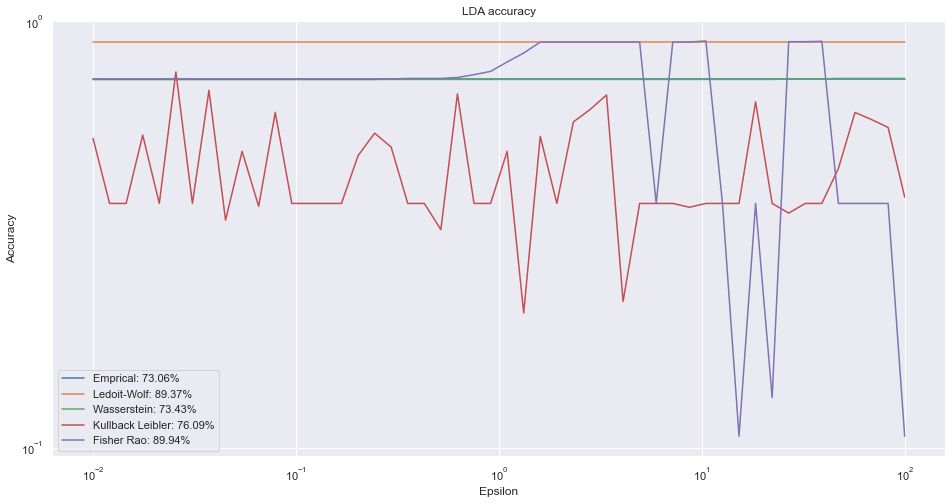

In [18]:
sns.set(rc={'figure.figsize':(16,8)})
grid = sns.lineplot(x=np.logspace(-2,2,50), y=[accuracy_empirical]*50, label='Emprical: {:.2f}%'.format(100*accuracy_empirical))
grid = sns.lineplot(x=np.logspace(-2,2,50), y=[accuracy_lw]*50, label='Ledoit-Wolf: {:.2f}%'.format(100*accuracy_lw))
grid = sns.lineplot(x=np.logspace(-2,2,50), y=accuracy_ws, label='Wasserstein: {:.2f}%'.format(100*max(accuracy_ws)))
grid = sns.lineplot(x=np.logspace(-2,2,50), y=accuracy_kl, label='Kullback Leibler: {:.2f}%'.format(100*max(accuracy_kl)))
grid = sns.lineplot(x=np.logspace(-2,2,50), y=accuracy_fr, label='Fisher Rao: {:.2f}%'.format(100*max(accuracy_fr)))
grid.set(xscale="log", yscale="log")
grid.legend()
grid.set_title('LDA accuracy')
grid.set_ylabel('Accuracy')
grid.set_xlabel('Epsilon');